## 论文图片

## 画全局路径图片

📊 数据统计:
   任务路径: 903 点, 长度: 2038.46 m
   测试路径: 1021 点, 长度: 2176.01 m


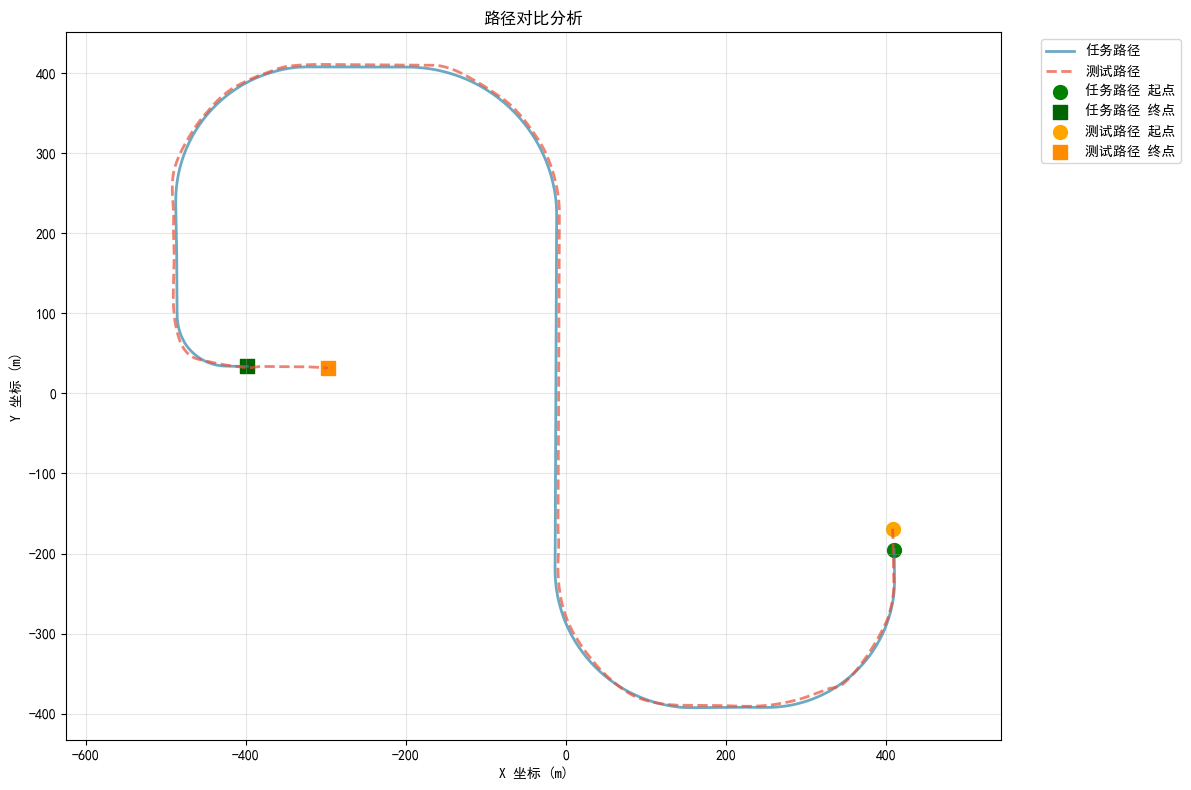

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Jupyter 环境配置
%matplotlib inline
# 设置中文字体支持 (根据你的系统可能需要调整，SimHei 适用于 Windows)
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.unicode_minus'] = False

# 2. 配置项 (代替原有的命令行参数)
CONFIG = {
    'csv1': 'global_vehicle_data.csv',
    'csv2': 'ego_vehicle_data.csv',
    'label1': '任务路径',
    'label2': '测试路径',
    'show_numbers': False,
    'title': '路径对比分析'
}

# 颜色方案
PATH_COLORS = {'path1': '#2E86AB', 'path2': '#E94F37'}

# --- 核心功能函数 ---

def load_csv_data(csv_file, label="文件"):
    if not os.path.exists(csv_file):
        print(f"❌ 警告：{label}未找到 - {csv_file}。请检查文件路径。")
        return None
    try:
        df = pd.read_csv(csv_file)
        required_cols = ['global_x', 'global_y']
        if all(col in df.columns for col in required_cols):
            return df
        else:
            print(f"❌ {label} 缺少必需列: {required_cols}")
            return None
    except Exception as e:
        print(f"❌ 加载{label}失败: {str(e)}")
        return None

def calculate_path_length(df):
    if df is None: return 0.0
    dx = np.diff(df['global_x'])
    dy = np.diff(df['global_y'])
    if 'global_z' in df.columns:
        dz = np.diff(df['global_z'])
        return np.sum(np.sqrt(dx**2 + dy**2 + dz**2))
    return np.sum(np.sqrt(dx**2 + dy**2))

def plot_two_paths_2d_jupyter(df1, df2, label1="任务路径", label2="测试路径", title="双路径对比"):
    fig, ax = plt.subplots(figsize=(12, 8))

    # 绘制路径
    ax.plot(df1['global_x'], df1['global_y'], color=PATH_COLORS['path1'], label=label1, alpha=0.7, lw=2)
    ax.plot(df2['global_x'], df2['global_y'], color=PATH_COLORS['path2'], label=label2, alpha=0.7, lw=2, linestyle='--')

    # 标记起点/终点
    ax.scatter(df1['global_x'].iloc[0], df1['global_y'].iloc[0], c='green', s=100, label=f'{label1} 起点')
    ax.scatter(df1['global_x'].iloc[-1], df1['global_y'].iloc[-1], c='darkgreen', marker='s', s=100, label=f'{label1} 终点')

    ax.scatter(df2['global_x'].iloc[0], df2['global_y'].iloc[0], c='orange', s=100, label=f'{label2} 起点')
    ax.scatter(df2['global_x'].iloc[-1], df2['global_y'].iloc[-1], c='darkorange', marker='s', s=100, label=f'{label2} 终点')

    ax.set_xlabel('X 坐标 (m)')
    ax.set_ylabel('Y 坐标 (m)')
    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

def plot_deviation_jupyter(df1, df2):
    min_len = min(len(df1), len(df2))
    dists = np.sqrt((df1['global_x'][:min_len].values - df2['global_x'][:min_len].values)**2 +
                    (df1['global_y'][:min_len].values - df2['global_y'][:min_len].values)**2)

    plt.figure(figsize=(12, 4))
    plt.plot(dists, color='#E94F37', lw=1.5)
    plt.fill_between(range(len(dists)), dists, alpha=0.2, color='#E94F37')
    plt.axhline(y=np.mean(dists), color='blue', linestyle='--', label=f'平均偏差: {np.mean(dists):.3f}m')
    plt.title("点对点路径偏差 (Distance Error)")
    plt.xlabel("数据点序号")
    plt.ylabel("偏差 (m)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

# --- 执行逻辑 ---

# 1. 加载数据
df1 = load_csv_data(CONFIG['csv1'], "路径1")
df2 = load_csv_data(CONFIG['csv2'], "路径2")

if df1 is not None and df2 is not None:
    # 2. 打印统计信息
    len1 = calculate_path_length(df1)
    len2 = calculate_path_length(df2)
    print(f"📊 数据统计:")
    print(f"   {CONFIG['label1']}: {len(df1)} 点, 长度: {len1:.2f} m")
    print(f"   {CONFIG['label2']}: {len(df2)} 点, 长度: {len2:.2f} m")

    # 3. 绘图
    plot_two_paths_2d_jupyter(df1, df2, CONFIG['label1'], CONFIG['label2'], CONFIG['title'])
    # plot_deviation_jupyter(df1, df2)
else:
    print("❌ 无法进行可视化。请确保 CSV 文件在当前目录下，或者修改 CONFIG 中的路径。")

## KDTree路径点匹配

In [62]:

import matplotlib.pyplot as plt
from Demos.win32console_demo import window_size
from scipy.spatial import KDTree

# 解决中文乱码
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.family"] = "sans-serif"
# 解决负号无法显示的问题
plt.rcParams['axes.unicode_minus'] = False

def process_and_visualize_with_error(global_file, ego_file):
    # 1. 加载数据

    print("正在加载数据...")
    global_df = pd.read_csv(global_file)    # 读取两个csv文件
    ego_df = pd.read_csv(ego_file)

    # --- 第一部分：全局路径分析 (转向识别) ---
    global_coords = global_df[['global_x', 'global_y']].values
    global_steer = global_df[['steer']].values
    dx = np.diff(global_coords[:, 0])
    dy = np.diff(global_coords[:, 1])
    headings = np.arctan2(dy, dx)   # 这个代表了相邻两个点之间的方向


    delta = np.diff(headings)   # 计算航向角之间的差值
    delta = (delta + np.pi) % (2 * np.pi) - np.pi # 处理角度跳变
    steering_deltas = np.zeros(len(global_df))

    steering_deltas[1:-1] = delta
    threshold = 0.005 # 转向阈值
    conditions = [(steering_deltas > threshold), (steering_deltas < -threshold)]
    choices = [0.1, -0.1]
    global_df['steering_type'] = np.select(conditions, choices, default=0)  # 这里存储的就是每个点对应的转向判断
    # print(global_df['steering_type'].shape) # (903,)
    # --- 第二部分：KDTree 路径匹配与误差计算 ---
    print("正在进行 KDTree 匹配并计算距离误差...")
    tree = KDTree(global_coords)
    ego_coords = ego_df[['global_x', 'global_y']].values

    # distances: 自车点到最近全局路径点的欧式距离
    # indices: 对应的全局路径点索引
    distances, indices = tree.query(ego_coords)
    ego_df['matched_index'] = indices
    ego_df['dist_error'] = distances/2 # 匹配误差
    ego_df['current_steering'] = global_df['steering_type'].iloc[indices].values

    # --- 第三部分：可视化展示 ---
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    relative_time = ego_df['timestamp'] - ego_df['timestamp'].iloc[0]
    global_relative_time = global_df['timestamp'] - global_df['timestamp'].iloc[0]
    print("global_relative_time shape:", global_relative_time.shape)
    print("global_steer shape:", global_steer.shape)

    # --- 第一张图：Steering Analysis ---

    # --- 第二张图：Map Matching Error ---
    plt.figure(figsize=(10, 5)) # 创建第二个画布
    plt.plot(relative_time, ego_df['dist_error'], color='#e67e22', linewidth=1.5, label='匹配误差')
    plt.fill_between(relative_time, ego_df['dist_error'], 0, color='#e67e22', alpha=0.1)

    mean_error = ego_df['dist_error'].mean()
    plt.axhline(mean_error, color='red', linestyle=':', label=f'平均误差: {mean_error:.3f}m')
    plt.xlabel('时间/s')
    plt.ylabel('距离误差/m')
    plt.title('路径点匹配误差')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('distance_error.png', dpi=300) # 保存第二张图
    plt.show()

    # 统计信息打印
    print("\n匹配误差统计：")
    print(f"最大偏差: {ego_df['dist_error'].max():.4f} 米")
    print(f"平均偏差: {mean_error:.4f} 米")

# 执行
process_and_visualize_with_error('global_vehicle_data.csv', 'ego_vehicle_data.csv')

error: (87, 'SetConsoleScreenBufferSize', '参数错误。')

## KDTree和暴力搜索对比

In [ ]:
import numpy as np
import time
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] =False

def benchmark_search_methods():
    # 1. 设置实验参数
    # 全局路径点规模（从100到50,000）
    data_sizes = [100, 500, 1000, 5000, 10000, 20000, 50000]
    # 待查寻的自车定位点数量（固定为100个，模拟连续100帧匹配）
    query_size = 100

    brute_force_times = []
    kdtree_times = []

    print(f"{'点集规模':<10} | {'暴力搜索 (s)':<15} | {'KDTree (s)':<15} | {'加速倍数':<10}")
    print("-" * 60)

    for n in data_sizes:
        # 生成随机全局参考点
        global_points = np.random.rand(n, 2)
        # 生成随机自车定位查询点
        query_points = np.random.rand(query_size, 2)

        # --- 方法 A: 暴力搜索 (Brute Force) ---
        start_bf = time.time()
        for qp in query_points:
            # 计算查询点到所有点的欧式距离：sqrt((x1-x2)^2 + (y1-y2)^2)
            distances = np.linalg.norm(global_points - qp, axis=1)
            _ = np.argmin(distances) # 找到最小值的索引
        end_bf = time.time()
        bf_duration = end_bf - start_bf
        brute_force_times.append(bf_duration)

        # --- 方法 B: KDTree 搜索 ---
        # 注意：KDTree 需要先构建树（建树耗时也应考虑，但在大量查询时可忽略）
        start_kd = time.time()
        tree = KDTree(global_points)
        _, _ = tree.query(query_points)
        end_kd = time.time()
        kd_duration = end_kd - start_kd
        kdtree_times.append(kd_duration)

        speedup = bf_duration / kd_duration if kd_duration > 0 else 0
        print(f"{n:<12} | {bf_duration:<17.5f} | {kd_duration:<17.5f} | {speedup:.1f}x")

    # 2. 可视化结果
    plt.figure(figsize=(10, 6))

    plt.plot(data_sizes, brute_force_times, 'r-', label='暴力求解 (O(N))')
    plt.plot(data_sizes, kdtree_times, 'g-', label='KDTree (O(log N))')
    plt.xlabel('参考点数')
    plt.ylabel('花费时间/s')
    plt.title('KDTree与暴力求解对比')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log') # 使用对数坐标轴能更清晰看到对比
    plt.savefig('kdtree_brute.svg', bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    benchmark_search_methods()

## 对比分析

### 不使用的

阈值：0.008, 滑动数量：8，多帧阈值：0.064


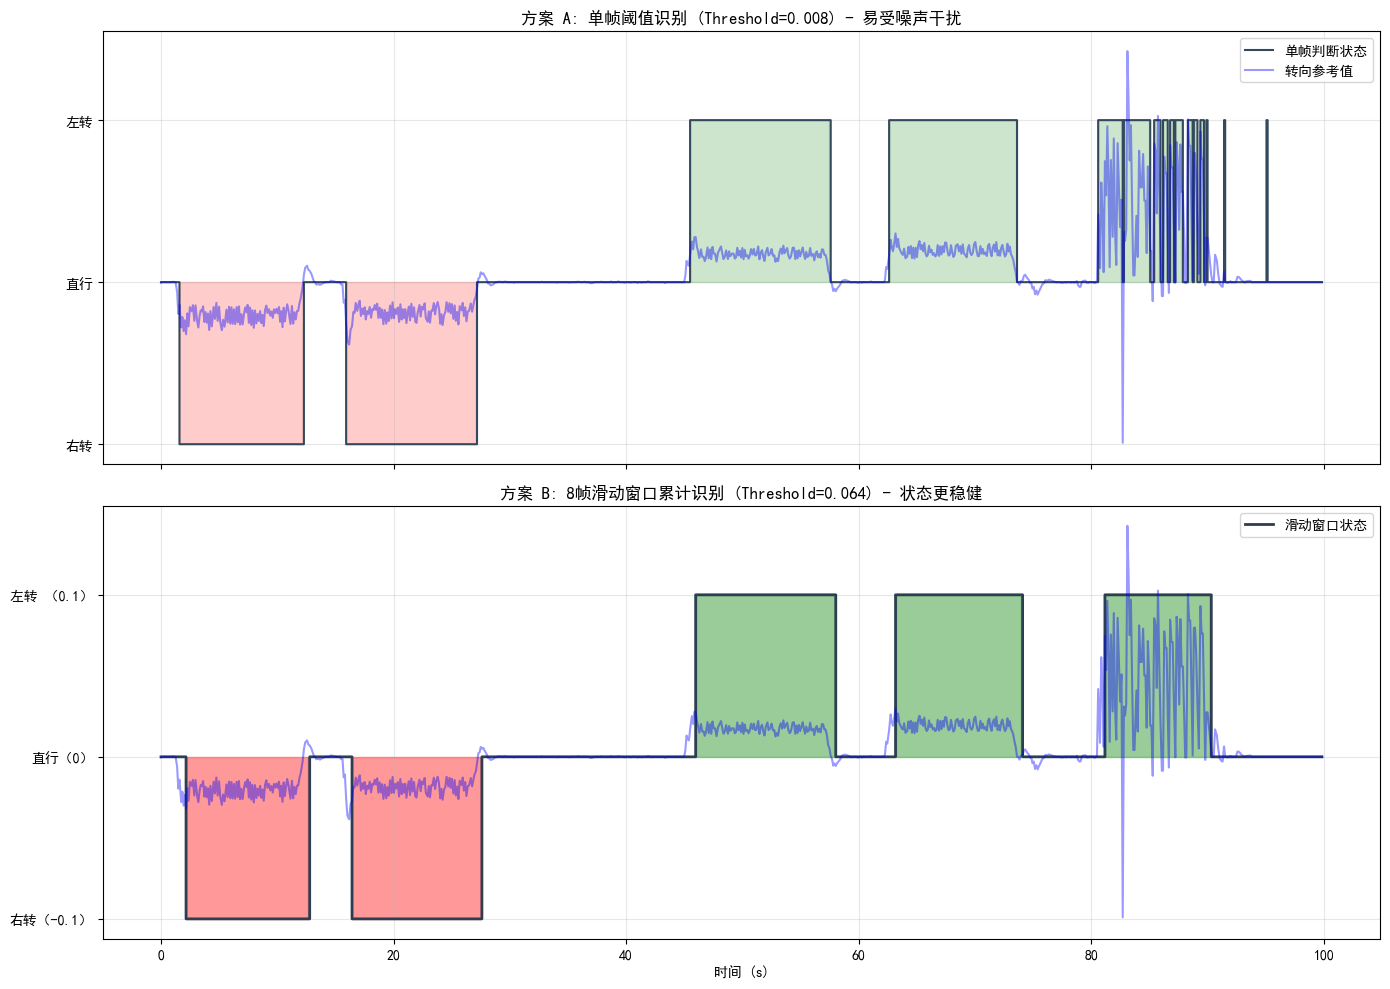

分析完成。方案B最大偏差: 50.2578m


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# 1. 环境配置
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.unicode_minus'] = False

def analyze_steering_logic(global_file, ego_file, window_size=8, threshold_single=0.008):
    """
    整合代码：同时进行单帧阈值与滑动窗口累计阈值的转向分析
    """
    threshold_accum=threshold_single*8
    print(f'阈值：{threshold_single}, 滑动数量：{window_size}，多帧阈值：{threshold_accum}')
    global_df = pd.read_csv(global_file)
    ego_df = pd.read_csv(ego_file)

    # --- 基础物理量计算 ---
    global_coords = global_df[['global_x', 'global_y']].values
    global_steer = global_df[['steer']].values

    # 计算航向角 (Headings) -> 长度 N-1
    dx = np.diff(global_coords[:, 0])
    dy = np.diff(global_coords[:, 1])
    headings = np.arctan2(dy, dx)

    # 计算帧间航向角差值 (Delta) -> 长度 N-2
    delta = np.diff(headings)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi

    # --- 逻辑 A: 单帧阈值判定 (旧逻辑) ---
    steering_single = np.zeros(len(global_df))
    # 单帧差分填充到 [1:-1]
    steering_single[1:-1] = delta
    cond_a = [(steering_single > threshold_single), (steering_single < -threshold_single)]
    global_df['type_single'] = np.select(cond_a, [0.1, -0.1], default=0)

    # --- 逻辑 B: 8帧滑动窗口累计判定 (新逻辑) ---
    # 计算滑动累计和
    accumulated_delta = pd.Series(delta).rolling(window=window_size, min_periods=1).sum().values
    steering_accum = np.zeros(len(global_df))
    # 累计差分填充到 [2:]
    steering_accum[2:] = accumulated_delta
    cond_b = [(steering_accum > threshold_accum), (steering_accum < -threshold_accum)]
    global_df['type_accum'] = np.select(cond_b, [0.1, -0.1], default=0)

    # --- KDTree 匹配与误差计算 ---
    tree = KDTree(global_coords)
    ego_coords = ego_df[['global_x', 'global_y']].values
    distances, indices = tree.query(ego_coords)

    ego_df['dist_error'] = distances / 2
    global_relative_time = global_df['timestamp'] - global_df['timestamp'].iloc[0]
    relative_time = ego_df['timestamp'] - ego_df['timestamp'].iloc[0]

    # --- 可视化：对比分析图 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # 子图1：单帧阈值 (无累计)
    ax1.step(global_relative_time, global_df['type_single'], where='post', color='#34495e', label='单帧判断状态')
    ax1.fill_between(global_relative_time, global_df['type_single'], 0, where=(global_df['type_single'] > 0), color='green', alpha=0.2, step='post')
    ax1.fill_between(global_relative_time, global_df['type_single'], 0, where=(global_df['type_single'] < 0), color='red', alpha=0.2, step='post')
    ax1.plot(global_relative_time, global_steer.flatten(), color='blue', alpha=0.4, label='转向参考值')
    ax1.set_title(f'方案 A: 单帧阈值识别 (Threshold={threshold_single}) - 易受噪声干扰')
    ax1.set_yticks([-0.1, 0, 0.1])
    ax1.set_yticklabels(['右转', '直行', '左转'])
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # 子图2：滑动窗口累计
    ax2.step(global_relative_time, global_df['type_accum'], where='post', color='#2c3e50', linewidth=2, label='滑动窗口状态')
    ax2.fill_between(global_relative_time, global_df['type_accum'], 0, where=(global_df['type_accum'] > 0), color='green', alpha=0.4, step='post')
    ax2.fill_between(global_relative_time, global_df['type_accum'], 0, where=(global_df['type_accum'] < 0), color='red', alpha=0.4, step='post')
    ax2.plot(global_relative_time, global_steer.flatten(), color='blue', alpha=0.4)
    ax2.set_title(f'方案 B: {window_size}帧滑动窗口累计识别 (Threshold={threshold_accum}) - 状态更稳健')
    ax2.set_yticks([-0.1, 0, 0.1])
    ax2.set_yticklabels(['右转（-0.1）', '直行（0）', '左转 （0.1）'])
    ax2.set_xlabel('时间 (s)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('steering_comparison_analysis.png', dpi=300)
    plt.show()


    print(f"分析完成。方案B最大偏差: {ego_df['dist_error'].max():.4f}m")

# 执行整合后的函数
threshold_values = [0.005, 0.01]
# threshold_single=0.008, windows_num=8
analyze_steering_logic('global_vehicle_data.csv', 'ego_vehicle_data.csv')

### 不使用的

配置参数 -> 单帧阈值：0.005, 滑动窗口：8, 多帧累计阈值：0.04


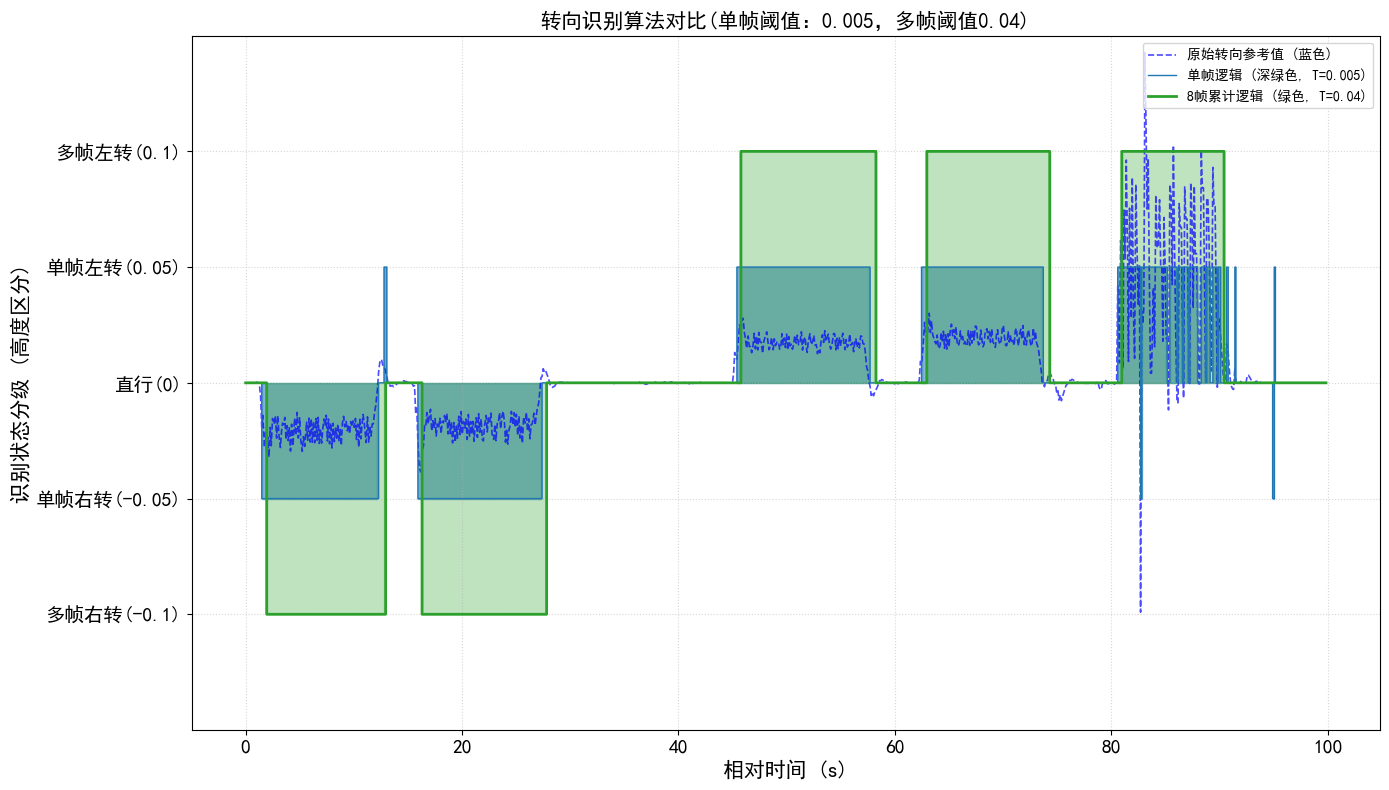

分析完成：黑色-参考值，蓝色-单帧，绿色-多帧。图像已生成。


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# 1. 环境配置
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.unicode_minus'] = False

def analyze_steering_logic_combined(global_file, ego_file, window_size=8, threshold_single=0.008):
    """
    整合对比图：将单帧与多帧结果放在同一个坐标系内
    颜色配置：参考值-黑色，单帧-蓝色，多帧-绿色
    """
    threshold_accum = threshold_single * window_size
    print(f'配置参数 -> 单帧阈值：{threshold_single}, 滑动窗口：{window_size}, 多帧累计阈值：{threshold_accum}')

    global_df = pd.read_csv(global_file)
    ego_df = pd.read_csv(ego_file)

    # --- 基础物理量计算 ---
    global_coords = global_df[['global_x', 'global_y']].values
    global_steer = global_df[['steer']].values

    dx = np.diff(global_coords[:, 0])
    dy = np.diff(global_coords[:, 1])
    headings = np.arctan2(dy, dx)

    delta = np.diff(headings)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi

    # --- 逻辑 A: 单帧阈值判定 (蓝色, 高度 0.05) ---
    steering_single_raw = np.zeros(len(global_df))
    steering_single_raw[1:-1] = delta
    cond_a = [(steering_single_raw > threshold_single), (steering_single_raw < -threshold_single)]
    global_df['type_single'] = np.select(cond_a, [0.05, -0.05], default=0)

    # --- 逻辑 B: 8帧滑动窗口累计判定 (绿色, 高度 0.1) ---
    accumulated_delta = pd.Series(delta).rolling(window=window_size, min_periods=1).sum().values
    steering_accum_raw = np.zeros(len(global_df))
    steering_accum_raw[2:] = accumulated_delta
    cond_b = [(steering_accum_raw > threshold_accum), (steering_accum_raw < -threshold_accum)]
    global_df['type_accum'] = np.select(cond_b, [0.1, -0.1], default=0)

    # --- 时间轴 ---
    global_relative_time = global_df['timestamp'] - global_df['timestamp'].iloc[0]

    # --- 可视化：单图对比展示 ---
    plt.figure(figsize=(14, 8))

    # 1. 绘制原始参考线 (黑色线)
    plt.plot(global_relative_time, global_steer.flatten(), color='blue', alpha=0.7,
             linewidth=1.2, linestyle='--', label='原始转向参考值 (蓝色)')

    # 2. 绘制单帧判定 (蓝色，较矮)
    plt.step(global_relative_time, global_df['type_single'], where='post', color='#1f77b4',
             linewidth=1, label=f'单帧逻辑 (深绿色, T={threshold_single})')
    # 蓝色填充
    plt.fill_between(global_relative_time, global_df['type_single'], 0,
                     where=(global_df['type_single'] != 0),
                     color='#1f77b4', alpha=0.55, step='post')

    # 3. 绘制多帧累计判定 (绿色，较高)
    plt.step(global_relative_time, global_df['type_accum'], where='post', color='#2ca02c',
             linewidth=2, label=f'{window_size}帧累计逻辑 (绿色, T={threshold_accum})')
    # 绿色填充
    plt.fill_between(global_relative_time, global_df['type_accum'], 0,
                     where=(global_df['type_accum'] != 0),
                     color='#2ca02c', alpha=0.3, step='post')

    # 坐标轴美化
    plt.xticks(fontsize=14)
    plt.yticks([-0.1, -0.05, 0, 0.05, 0.1],
               ['多帧右转(-0.1)', '单帧右转(-0.05)', '直行(0)', '单帧左转(0.05)', '多帧左转(0.1)'], fontsize=14)
    plt.title(f'转向识别算法对比(单帧阈值：{threshold_single}，多帧阈值{threshold_accum})', fontsize=15)
    plt.xlabel('相对时间 (s)', fontsize=15)
    plt.ylabel('识别状态分级 (高度区分)', fontsize=15)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='upper right', frameon=True)

    # 限制纵坐标范围，让图看起来更协调
    plt.ylim(-0.15, 0.15)

    plt.tight_layout()
    plt.savefig('steering.png', dpi=400)
    plt.show()

    print("分析完成：黑色-参考值，蓝色-单帧，绿色-多帧。图像已生成。")

# 执行
threshold_values = [0.005, 0.01]
window_sizes = [8, 4]
analyze_steering_logic_combined('global_vehicle_data.csv', 'ego_vehicle_data.csv', window_size=window_sizes[0], threshold_single=threshold_values[0])


### 四个子图模式

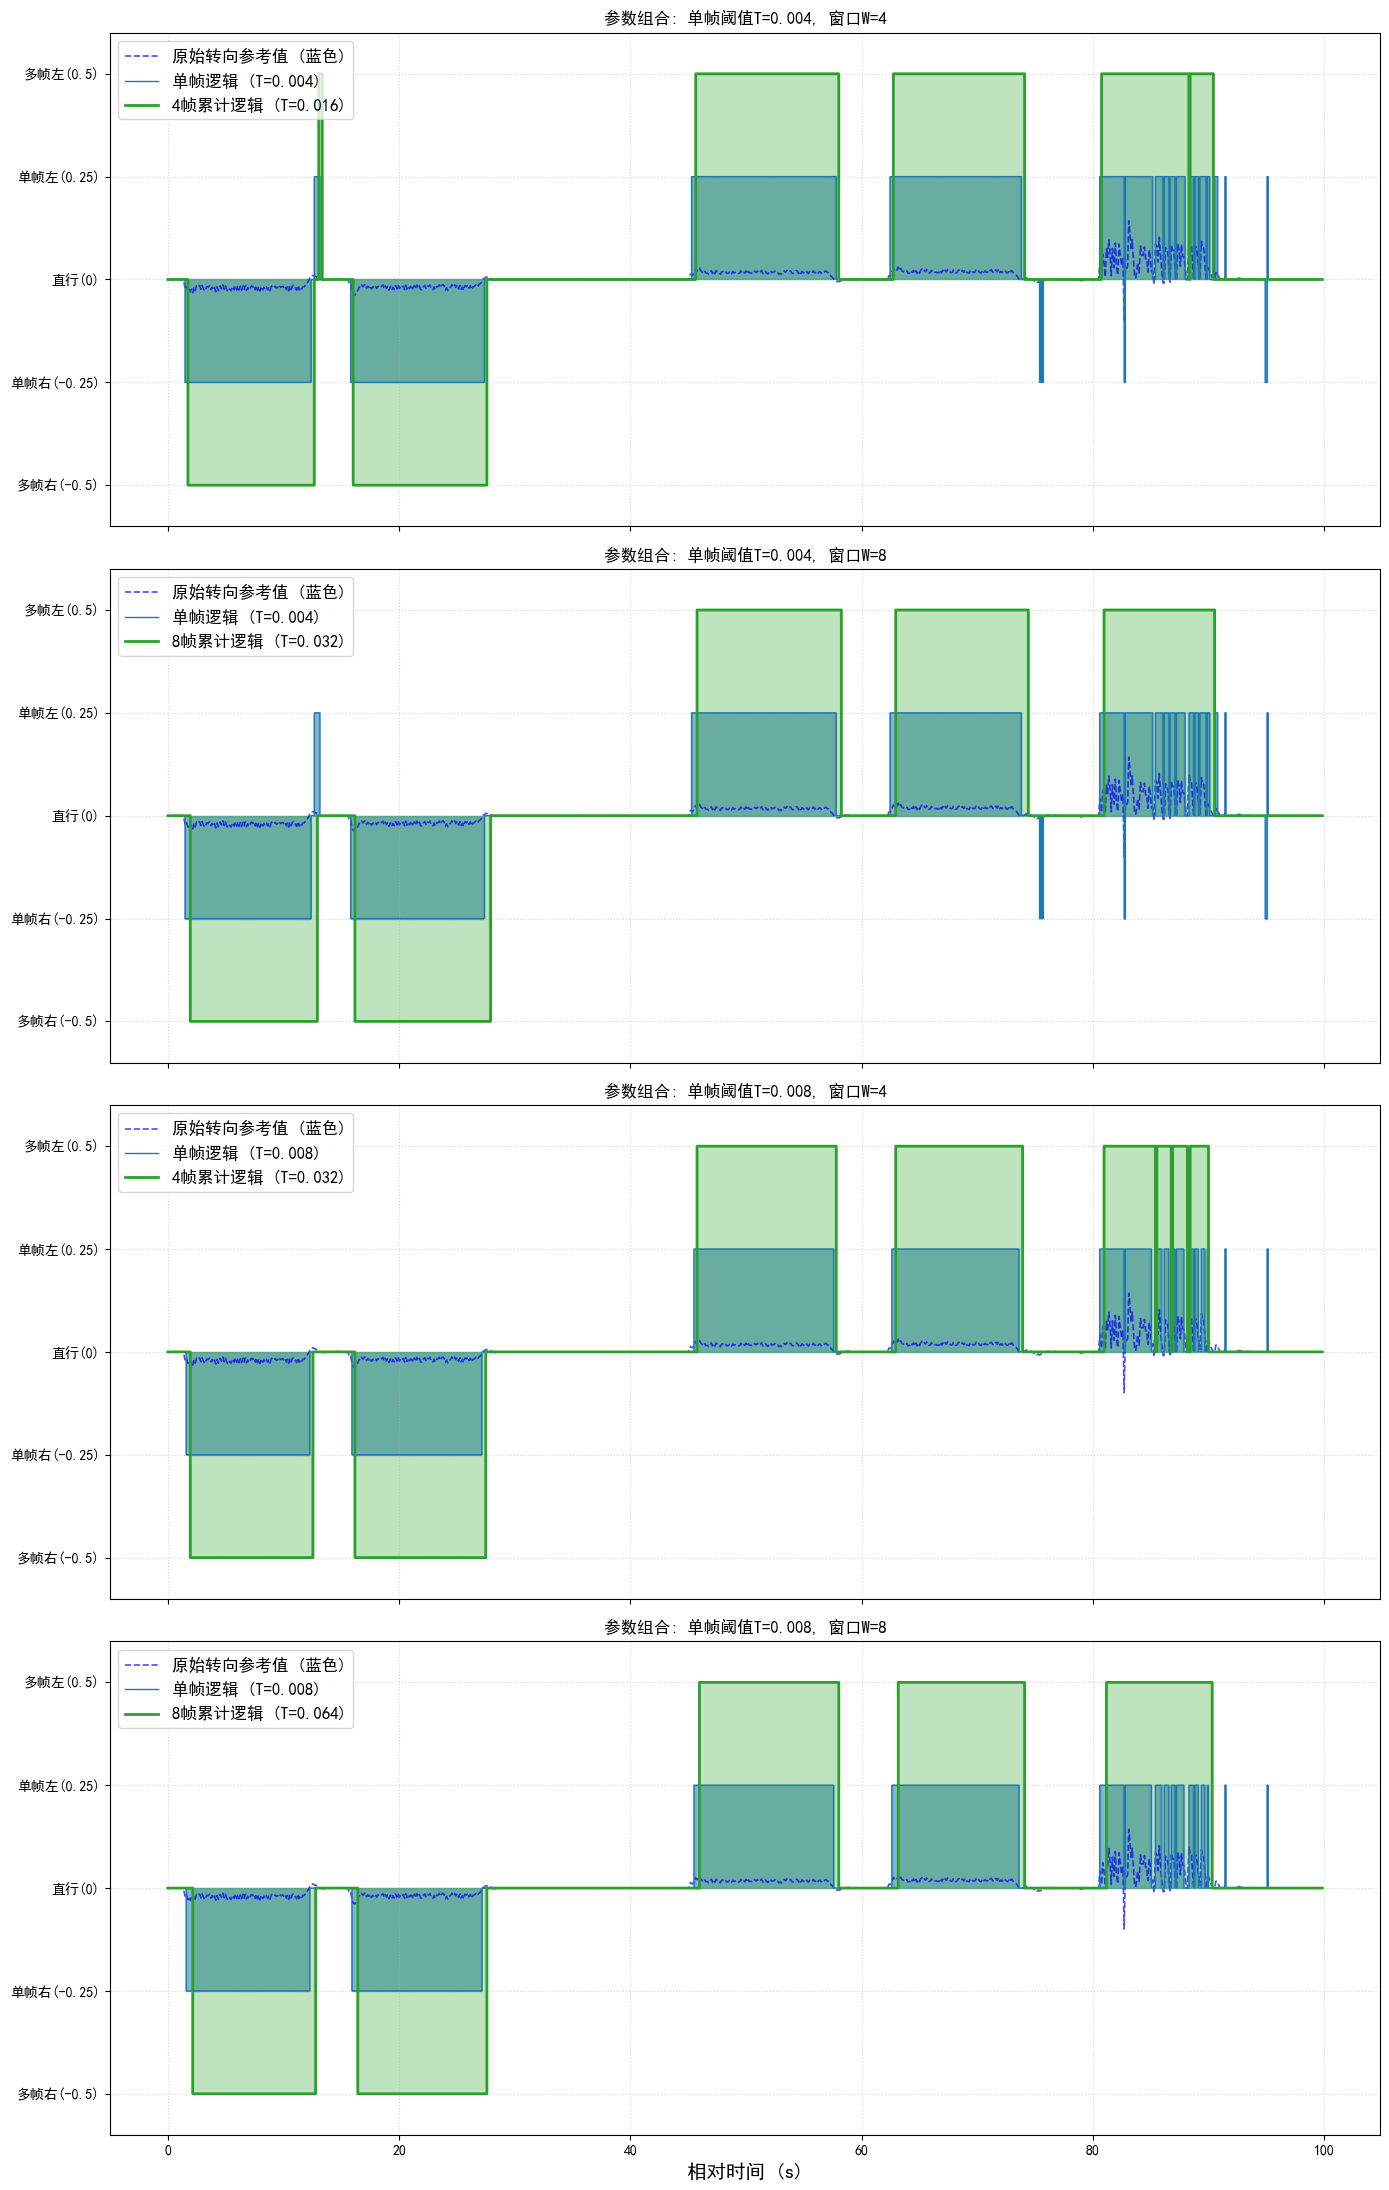

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 环境配置
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.unicode_minus'] = False

def plot_steering_subplot(ax, global_df, window_size, threshold_single):
    """
    在指定的 ax 上绘制单组参数的转向识别结果
    """
    threshold_accum = threshold_single * window_size

    # --- 基础物理量计算 ---
    global_coords = global_df[['global_x', 'global_y']].values
    global_steer = global_df[['steer']].values

    dx = np.diff(global_coords[:, 0])
    dy = np.diff(global_coords[:, 1])
    headings = np.arctan2(dy, dx)

    delta = np.diff(headings)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi

    # --- 逻辑 A: 单帧阈值判定 (蓝色) ---
    steering_single_raw = np.zeros(len(global_df))
    steering_single_raw[1:-1] = delta
    cond_a = [(steering_single_raw > threshold_single), (steering_single_raw < -threshold_single)]
    type_single = np.select(cond_a, [0.25, -0.25], default=0)

    # --- 逻辑 B: 滑动窗口累计判定 (绿色) ---
    accumulated_delta = pd.Series(delta).rolling(window=window_size, min_periods=1).sum().values
    steering_accum_raw = np.zeros(len(global_df))
    steering_accum_raw[2:] = accumulated_delta
    cond_b = [(steering_accum_raw > threshold_accum), (steering_accum_raw < -threshold_accum)]
    type_accum = np.select(cond_b, [0.5, -0.5], default=0)

    # --- 时间轴 ---
    global_relative_time = global_df['timestamp'] - global_df['timestamp'].iloc[0]

    # --- 绘图逻辑 (保持原有颜色和图例) ---
    # 1. 原始参考线
    ax.plot(global_relative_time, global_steer.flatten(), color='blue', alpha=0.7,
             linewidth=1.2, linestyle='--', label='原始转向参考值 (蓝色)')

    # 2. 单帧判定
    ax.step(global_relative_time, type_single, where='post', color='#1f77b4',
             linewidth=1, label=f'单帧逻辑 (T={threshold_single})')
    ax.fill_between(global_relative_time, type_single, 0,
                     where=(type_single != 0),
                     color='#1f77b4', alpha=0.55, step='post')

    # 3. 多帧累计判定
    ax.step(global_relative_time, type_accum, where='post', color='#2ca02c',
             linewidth=2, label=f'{window_size}帧累计逻辑 (T={threshold_accum:.3f})')
    ax.fill_between(global_relative_time, type_accum, 0,
                     where=(type_accum != 0),
                     color='#2ca02c', alpha=0.3, step='post')

    # 坐标轴美化
    ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax.set_yticklabels(['多帧右(-0.5)', '单帧右(-0.25)', '直行(0)', '单帧左(0.25)', '多帧左(0.5)'], fontsize=10)
    ax.set_title(f'参数组合: 单帧阈值T={threshold_single}, 窗口W={window_size}', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper left', frameon=True, fontsize=12)
    ax.set_ylim(-0.6, 0.6)

# --- 主执行程序 ---
def analyze_all_combinations(global_file, threshold_values, window_sizes):
    global_df = pd.read_csv(global_file)

    # 准备组合列表 [(0.005, 8), (0.005, 4), (0.01, 8), (0.01, 4)]
    combinations = [(t, w) for t in threshold_values for w in window_sizes]

    # 创建 4 行 1 列的画布
    fig, axes = plt.subplots(4, 1, figsize=(14, 22), sharex=True)

    for i, (t_val, w_val) in enumerate(combinations):
        plot_steering_subplot(axes[i], global_df, w_val, t_val)

    axes[-1].set_xlabel('相对时间 (s)', fontsize=14)
    plt.tight_layout()
    plt.savefig('steering_combined_analysis.png', dpi=400)
    plt.show()

# 执行
threshold_values = [0.004, 0.008]
window_sizes = [1, 4, 8]
analyze_all_combinations('global_vehicle_data.csv', threshold_values, window_sizes)

### 两子图模式

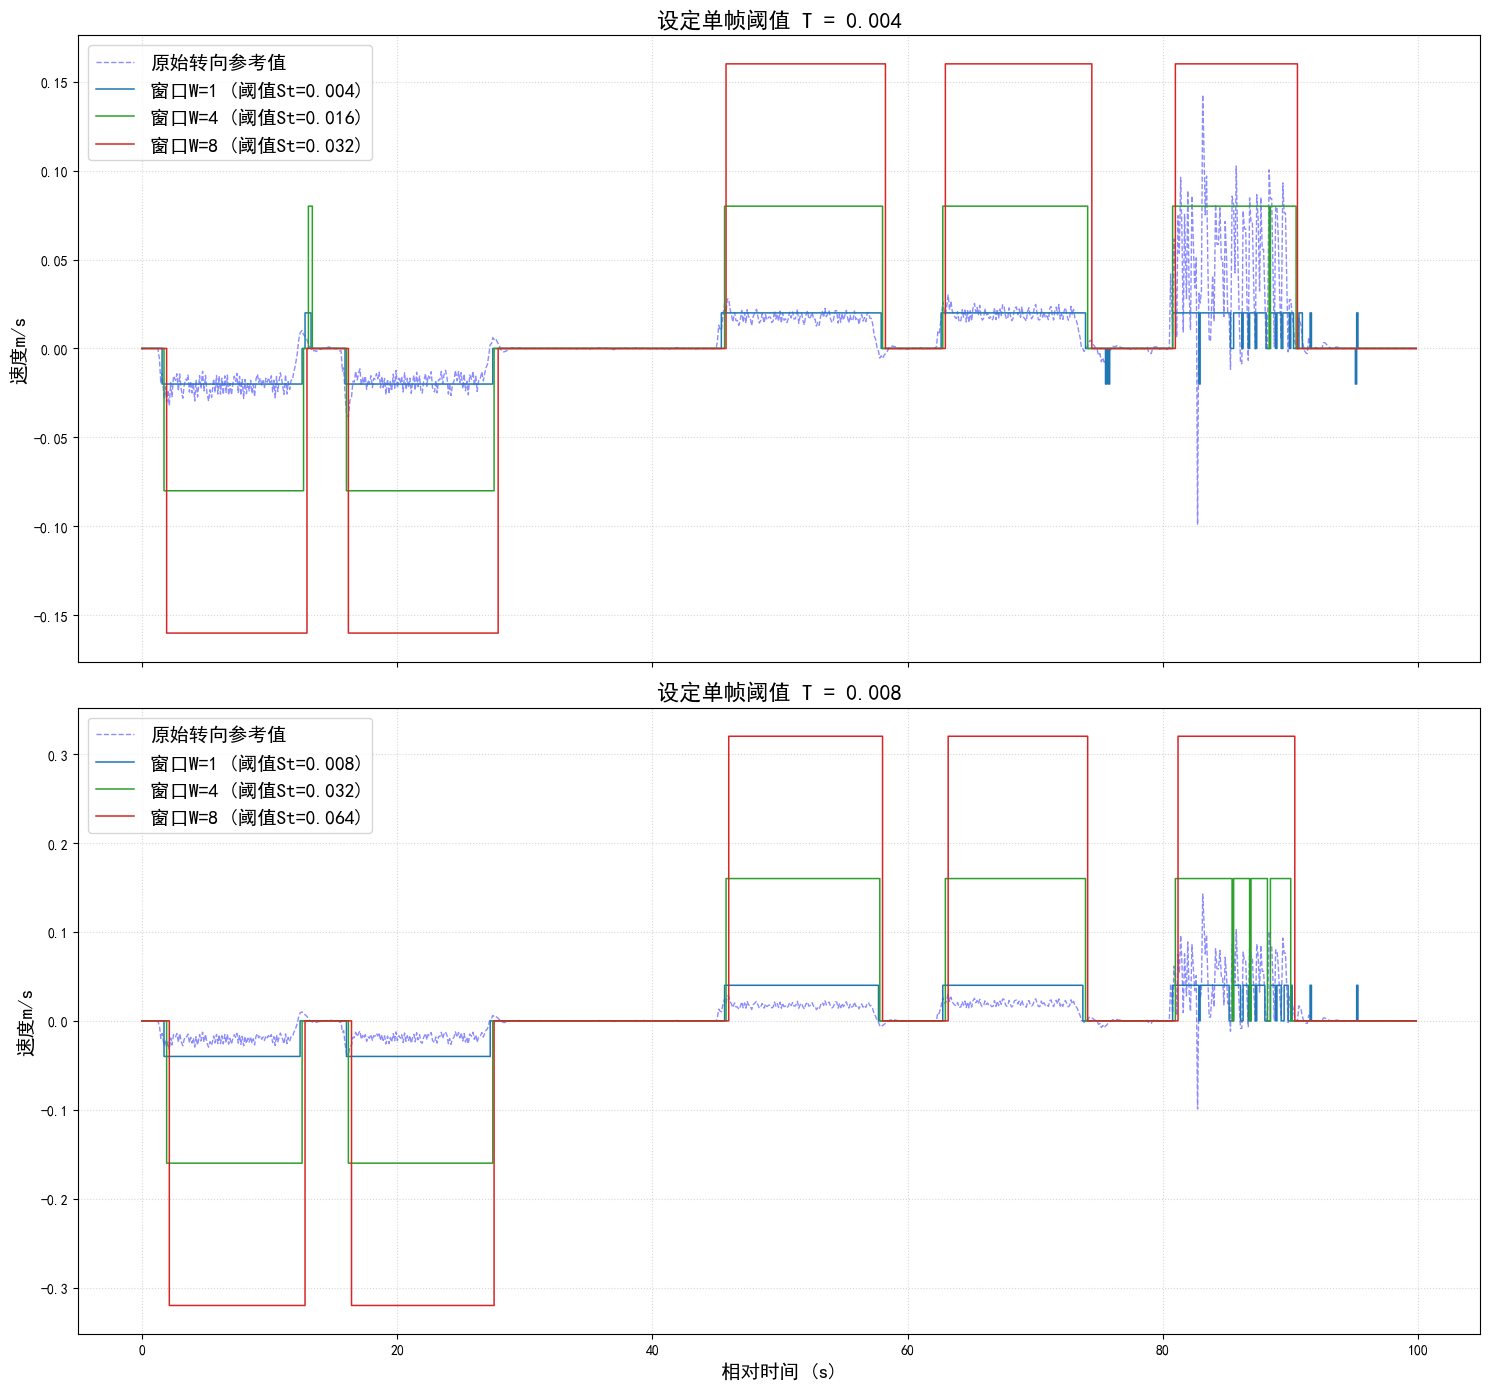

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 环境配置
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.unicode_minus'] = False

def plot_steering_by_threshold(ax, global_df, t_val, window_sizes):
    """
    在单个 ax 上绘制同一个阈值下，不同窗口大小的结果
    高度由 threshold_single * window_size 决定
    """
    # 时间轴
    global_relative_time = global_df['timestamp'] - global_df['timestamp'].iloc[0]

    # 基础物理量计算
    global_coords = global_df[['global_x', 'global_y']].values
    global_steer = global_df[['steer']].values
    dx = np.diff(global_coords[:, 0])
    dy = np.diff(global_coords[:, 1])
    headings = np.arctan2(dy, dx)
    delta = np.diff(headings)
    delta = (delta + np.pi) % (2 * np.pi) - np.pi

    # 1. 绘制原始参考线 (blue虚线作为基准)
    ax.plot(global_relative_time, global_steer.flatten(), color='blue', alpha=0.45,
             linewidth=1, linestyle='--', label='原始转向参考值')

    # 定义颜色循环，方便区分不同窗口
    colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

    for idx, w_val in enumerate(window_sizes):
        threshold_accum = t_val * w_val
        # 判定高度设置为 threshold * window
        height = threshold_accum*5

        # --- 累计逻辑计算 ---
        accumulated_delta = pd.Series(delta).rolling(window=w_val, min_periods=1).sum().values
        steering_accum_raw = np.zeros(len(global_df))
        steering_accum_raw[2:] = accumulated_delta

        cond = [(steering_accum_raw > threshold_accum), (steering_accum_raw < -threshold_accum)]
        type_accum = np.select(cond, [height, -height], default=0)

        # --- 绘图 ---
        current_color = colors[idx % len(colors)]
        label_name = f'窗口W={w_val} (阈值St={threshold_accum:.3f})'

        ax.step(global_relative_time, type_accum, where='post', color=current_color,
                 linewidth=1.1, label=label_name)
        # ax.fill_between(global_relative_time, type_accum, 0,
        #                  where=(type_accum != 0),
        #                  color=current_color, alpha=0.2, step='post')

    # 坐标轴美化
    ax.set_title(f'设定单帧阈值 T = {t_val}', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle=':', alpha=0.5)
    # 放大图例文字
    ax.legend(loc='upper left', frameon=True, fontsize=14, prop={'size': 14})
    ax.set_ylabel('速度m/s', fontsize=14)

# --- 主执行程序 ---
def analyze_by_threshold_groups(global_file, threshold_values, window_sizes):
    global_df = pd.read_csv(global_file)

    # 创建 2 行 1 列的画布
    fig, axes = plt.subplots(len(threshold_values), 1, figsize=(15, 14), sharex=True)

    # 如果只有一个阈值，axes 不是数组，需要处理
    if len(threshold_values) == 1:
        axes = [axes]

    for i, t_val in enumerate(threshold_values):
        plot_steering_by_threshold(axes[i], global_df, t_val, window_sizes)

    axes[-1].set_xlabel('相对时间 (s)', fontsize=14)
    plt.tight_layout()
    plt.savefig('steering_threshold_group.png', dpi=500)
    plt.show()

# 执行：两个阈值子图，每个子图内展示 3 种窗口效果
threshold_values = [0.004, 0.008]
window_sizes = [1, 4, 8]
analyze_by_threshold_groups('global_vehicle_data.csv', threshold_values, window_sizes)